<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S7/S7_CIFAR10_WithDilation_DepthWise_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [4]:
#Data augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Batch Size of 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



horse  deer  bird horse truck   car   cat  bird plane   dog  ship   dog   cat  frog   car   car  deer  frog  frog  deer   car truck horse  deer   car  ship  frog   car   dog  ship  ship   dog


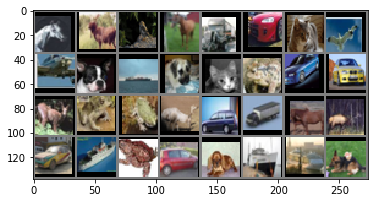

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1,  stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        ) #Output size=32 RF=1

        #Apply Depth wise separation(group)
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, groups=32, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        ) #Output size=32 RF=1

        self.pool1 = nn.MaxPool2d(2,2) #Output size=16 RF=1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
        )  #Output size=16 RF=5

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )  #Output size=16 RF=9
        self.pool2 = nn.MaxPool2d(2,2)  #Output size=8 RF=11

        #Apply Dilation of 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2, stride=1, dilation=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value),
        )  #Output size=8 RF=27

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )  #Output size=8 RF=35

        self.pool3 = nn.MaxPool2d(2,2)  #Output size=4 RF=39

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )  #Output size=4 RF=55


        #GAP Layer
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )    #  RF = 79  

        #FC
        self.fc = nn.Linear(in_features=128,out_features=10)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x) 
        x = self.convblock4(x)
        
        x = self.pool2(x)    
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool3(x) 
        x = self.convblock7(x)
        
        x = self.gap(x)  
        x = x.view(-1,128)
        x = self.fc(x)      
         
        return x

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,432
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
          Dropout-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1

In [0]:
import torch.optim as optim

cuda_avail = torch.cuda.is_available()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [0]:
def test():
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
      for i, (images, labels) in enumerate(testloader):

        if cuda_avail:
          images = Variable(images.cuda())
          labels = Variable(labels.cuda())

        	# Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        test_acc += torch.sum(prediction == labels.data)

    #Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / 10000

    return test_acc

In [0]:
def train(num_epochs):
  for epoch in range(num_epochs):	
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        # Move images and labels to gpu if available
        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Clear all accumulated gradients
        optimizer.zero_grad()
        # Predict classes using images from the test set
        outputs = model(images)
        # Compute the loss based on the predictions and actual labels
        loss = criterion(outputs, labels)
        # Backpropagate the loss
        loss.backward()

        # Adjust parameters according to the computed gradients
        optimizer.step()

        _, prediction = torch.max(outputs.data, 1)
        
        train_acc += torch.sum(prediction == labels.data)


    # Compute the average acc and loss over all 50000 training images
    train_acc = train_acc / 50000

    # Evaluate on the test set
    test_acc = test()


    # Print the accuracy
    print("Epoch {}, Train Accuracy: {} , Test Accuracy: {}".format(epoch, train_acc, test_acc))

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


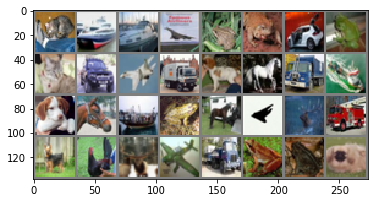

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [25]:
#Number of epochs as parameter
train(10)

Epoch 0, Train Accuracy: 0.8094399571418762 , Test Accuracy: 0.809499979019165
Epoch 1, Train Accuracy: 0.8143599629402161 , Test Accuracy: 0.824999988079071
Epoch 2, Train Accuracy: 0.8208199739456177 , Test Accuracy: 0.8159999847412109
Epoch 3, Train Accuracy: 0.8261599540710449 , Test Accuracy: 0.8048999905586243
Epoch 4, Train Accuracy: 0.8294999599456787 , Test Accuracy: 0.8373000025749207
Epoch 5, Train Accuracy: 0.8337399959564209 , Test Accuracy: 0.8355000019073486
Epoch 6, Train Accuracy: 0.8387399911880493 , Test Accuracy: 0.833899974822998
Epoch 7, Train Accuracy: 0.8422200083732605 , Test Accuracy: 0.8379999995231628
Epoch 8, Train Accuracy: 0.8464599847793579 , Test Accuracy: 0.8414999842643738
Epoch 9, Train Accuracy: 0.8495599627494812 , Test Accuracy: 0.8481000065803528


Got accuracy of 80% within 10 epoch

1.   Applied 3 Max pool layers
2.   Applied Dilation CNN
3.   Applied Depth-wise CNN
4.   Followed ResNet architecture.At the end applied GAP followed by FC
5.   Final Receptive field is 79